# Applying Decision Trees on Amazon fine food reviews Dataset

Context:-
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

Contents
Reviews.csv: Pulled from the corresponding SQLite table named Reviews in database.sqlite
database.sqlite: Contains the table 'Reviews'

Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

Features

- Id
- ProductId (Unique identifier for the product)
- UserId (Unqiue identifier for the user)
- ProfileName (Profile name of the user)
- HelpfulnessNumerator (Number of users who found the review helpful)
- HelpfulnessDenominator (Number of users who indicated whether they found the review helpful)
- ScoreRating (between 1 and 5)
- TimeTimestamp (for the review)
- SummaryBrief (summary of the review)
- Text (Text of the review)

We will use Decision Trees to predict the reviews as +ve or -ve with maximum accuracy.
Here we will also be using Grid search cross-validation to predict the optimal hyper parameters.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
import sqlite3
import pandas as pd
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

##### 2. Connecting to Amazon food review dataset

In [49]:
con=sqlite3.connect('./database.sqlite')
filtered_data=pd.read_sql_query("""select * from reviews where score!=3""",con)
def partition(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'
actual_score=filtered_data['Score']
PositiveNegative=actual_score.map(partition)
filtered_data['Score']=PositiveNegative
print(filtered_data.shape)
filtered_data.head()


(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


##### 3. Sorting our data on the basis of date and removing the Duplicate reviews

In [50]:
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
print(final.shape)

(364173, 10)


##### 4. we are also removing the rows which has HelpfulnessDenominator greater then HelpfulnessNumerator because its not practically possile 

In [51]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [52]:
print(final.shape)

(364171, 10)


In [53]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#### we are also cleaning our text of html tags , stop words, and puncuations

In [54]:
# find sentences containing HTML tags

import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [55]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"that'll", 'aren', 'hasn', 'because', 'yours', 'mightn', 'myself', 'then', 'nor', 'him', 'she', 'with', 'wouldn', 'or', 'to', 'didn', 'these', 'yourselves', 'other', 'shan', "haven't", 'at', 'that', 'each', 'where', 'some', 'can', 'll', 'ma', 'against', "hadn't", 'same', 'until', 'wasn', 'about', 'no', 'isn', 'their', "shan't", 'himself', 'off', 'yourself', 'between', 'am', 'most', "didn't", 'this', 'up', 'our', 'o', "wouldn't", 'in', "couldn't", 'themselves', 'further', "hasn't", 'on', 'by', 'during', "you'll", 'below', 'he', "she's", 'its', 'i', 'they', 'just', 'hers', 'was', 'again', 'out', 'those', 'than', 're', 'both', 'does', 'here', 'as', 'had', 'have', 'y', "aren't", 'why', "don't", 'an', 'doing', 'only', "won't", 'd', 'theirs', 'what', 'haven', 'ain', 'whom', 'how', 'were', 'is', 'be', 'from', 'there', 'ours', 'been', 'such', 'weren', 'don', "you've", 'before', 's', 'after', 'above', 'over', "you're", 'them', 've', 'has', 'do', "doesn't", "mightn't", "needn't", 't', 'won', 'o

In [56]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [57]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [58]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

##### 6. Here we are Seperating all the review information of user on the basis of their Score i.e positive or negative. 
Then we are taking 306913 positive and 57087 negative reviews respectively from positive and negative data frame and we are concating them together in one data frame bigdata. We are also taking the scores of these 364000 reviews seperately in s1.
We then divide 364000 reviews to train and test data, and we convert the text column of the test and train into BOW. 


In [73]:
total_data=final.sample(364000)

In [262]:
bigdata=total_data

In [263]:
#Again sorting our data in Ascending order
sorted_data=bigdata.sort_values('Time',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')


In [264]:
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
123124,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
49506,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
115340,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
246829,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
281412,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [265]:
bigdata=sorted_data
s1=bigdata['Score']
print(s1.shape)
print(s1[3])

(364000,)
positive


In [266]:
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(bigdata, s1, test_size=0.3, random_state=0,shuffle = False, stratify = None)

Converting the train data sentences into group of words

In [309]:
# Train your own Word2Vec model using your own text corpus for train Data
import gensim
i=0
list_of_sent_train=[]
for sent in X_1['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)
    

In [310]:
# min_count = 5 considers only words that occured atleast 5 times
import gensim
from gensim import models
from gensim.models import Word2Vec, KeyedVectors
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  28931
sample words  ['i', 'buy', 'a', 'case', 'of', 'this', 'pasta', 'every', 'year', 'at', 'christmas', 'time', 'for', 'my', 'mom', 'she', 'is', 'diabetic', 'and', 'cant', 'get', 'product', 'locally', 'loves', 'the', 'flavor', 'texture', 'it', 'has', 'little', 'impact', 'on', 'her', 'blood', 'sugar', 'so', 'allows', 'to', 'have', 'dishes', 'without', 'wreaking', 'havoc', 'diabetes', 'great', 'ive', 'been', 'using', 'exclusively', 'past']


In [269]:

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

254800
50


In [270]:
sent_vectors_train[1]

array([-0.40207397, -0.35106349,  0.35093872,  0.99454606,  0.16100391,
       -0.096713  , -0.03767423,  0.44333053,  0.26914067, -0.60314979,
        0.16413334,  0.6563085 , -0.27041831, -0.59170505,  0.24819067,
       -0.47579619,  0.5615726 ,  0.5320993 ,  0.11077614,  1.12005389,
       -0.83678645, -0.36526086, -1.03545482, -0.39853309,  0.56024193,
       -0.06269347, -0.2198121 , -0.12194968,  0.00360922, -0.65960924,
       -0.26323688,  0.14549124,  0.23561719, -0.30327201,  0.06795227,
       -0.15390106,  0.33638524,  0.30933941, -0.26511796, -0.20675624,
        0.85091979,  0.66159272, -0.21231548, -0.25527165,  0.07175756,
        0.63921444,  1.07984748,  0.77643287,  0.06453216, -0.0946168 ])

Converting test data sentences into group of words

In [271]:
# Train your own Word2Vec model using your own text corpus for test Data
import gensim
i=0
list_of_sent_test=[]
for sent in X_test['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)
    

In [272]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  20063
sample words  ['i', 'never', 'liked', 'tomato', 'sauce', 'on', 'my', 'pasta', 'until', 'tried', 'this', 'cherry', 'its', 'naturally', 'a', 'little', 'sweeter', 'than', 'most', 'sauces', 'is', 'quite', 'peppery', 'and', 'as', 'the', 'other', 'commenter', 'noted', 'very', 'fresh', 'tasting', 'it', 'tastes', 'almost', 'good', 'making', 'yourself', 'im', 'excited', 'to', 'find', 'amazon', 'costco', 'no', 'longer', 'carries', 'have', 'drink', 'decaf']


In [273]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

109200
50


##### Standardizing our Train and Test word2vec vectors 

In [276]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
#np.isnan(sent_vectors_train.values.any())
#Where sent_vectors_train is my pandas Dataframe 
standardized_data_train = StandardScaler(with_mean=False).fit_transform(sent_vectors_train)
print(standardized_data_train.shape)

(254800, 50)


In [277]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
standardized_data_test = StandardScaler(with_mean=False).fit_transform(sent_vectors_test)
print(standardized_data_test.shape)

(109200, 50)


In [278]:
big_data=standardized_data_train

In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression


The optimal number of neighbors is 9.


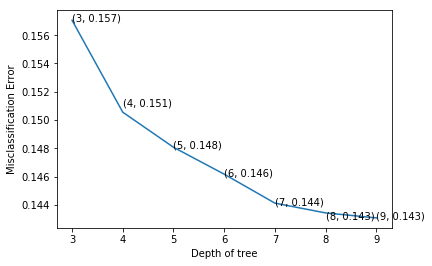

the misclassification error for each depth value is :  [0.157 0.151 0.148 0.146 0.144 0.143 0.143]


In [280]:
# creating odd list of K for KNN
myList = list(range(3,10))
neighbors = myList

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    clf=DecisionTreeClassifier(max_depth=k)
    scores = cross_val_score(clf, big_data, y_1, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Depth of tree')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each depth value is : ", np.round(MSE,3))

In [281]:
clf=DecisionTreeClassifier(max_depth=9)
clf.fit(big_data,y_1)
y_pred=clf.predict(standardized_data_test)

In [282]:
acc=accuracy_score(y_test,y_pred)*100

In [283]:
print('\nTest accuracy for depth=9 is %d%%' % ( acc))


Test accuracy for depth=9 is 76%


#### Confusion matrix , Precision, Recall, F-Score

In [284]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)



[[ 7505  9557]
 [16220 75918]]


In [285]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


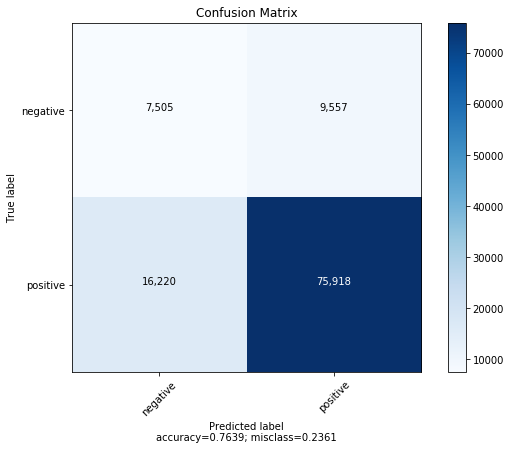

In [286]:
plot_confusion_matrix(gb, 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

In [287]:
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
recall

0.8239597126050056

In [288]:
#precision From above Confusion Metric
pre=(gb[1,1]+0.0)/sum(gb[:,1])
print(pre)

0.8881895291020766


In [289]:
# caculating F1 Score By using HP i.e 
#F1=2*TP/2*TP+FP+FN
F1=(2*pre*recall)/(pre+recall)
F1

0.8548698574991697

### Conclusion / Summary

Decision Trees are Fairly simple to use.
=>We choose 50 dimensional Word Vectors, becoz Decision trees don't work too well in higher dimensions.
Plotting The Errors for different depths of the tree we get :-
1. Best Depth:- 9
2. Test Accuracy:- 76%
3. Precision:-    0.88    
4. Recall:-  0.82  
5. F1-Score:-  0.85
    
Confusion Matrix:-
<img src="hmm.png">